# State of the Problem 1: EFFECTS OF METEOROLOGICAL FACTORS TO DENGUE CASES

## PYTHON TOOLS NEEDED

In [11]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

## SEIR MODEL

In [12]:
# 1. Model with Meteorological Factors
def seir_with_meteo(y, t, beta_0, sigma, gamma, temp, rain, humidity):
    S_h, E_h, I_h, R_h = y
    N = S_h + E_h+ I_h + R_h

    beta = beta_0 * (1 + 0.02 * temp[int(t)]) * (1 + 0.02 * rain[int(t)]) * (1 + 0.02 * humidity[int(t)])

    # SEIR (Human) equations
    dS_hdt = -beta * S_h * I_h / N
    dE_hdt = (beta * S_h * I_h / N) - (sigma * E_h)
    dI_hdt = (sigma * E_h) - (gamma * I_h)
    dR_hdt = gamma * I_h

    return [dS_hdt, dE_hdt, dI_hdt, dR_hdt]

In [13]:
# 2. Model without Meteorological Factors
def standard_seir(y, t, beta_0, sigma, gamma):
    S_h, E_h, I_h, R_h = y
    N = S_h + E_h + I_h + R_h

    # Constant transmission rate
    beta = beta_0

    # SEIR (Human) equations
    dS_hdt = -beta * S_h * I_h / N
    dE_hdt = (beta * S_h * I_h / N) - (sigma * E_h)
    dI_hdt = (sigma * E_h) - (gamma * I_h)
    dR_hdt = gamma * I_h

    return [dS_hdt, dE_hdt, dI_hdt, dR_hdt]

## ACCURACY EVALUATION CALCULATION

In [14]:
# Function to evaluate model accuracy
def evaluate_model(y_true, y_pred):
    """Calculates RMSE and R-squared."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    return rmse, r_squared

## SIMULATION AND EVALUATION

In [15]:
dengue_cases = pd.read_csv('cleaned_dengue_data.csv')

# Example Data and Parameters
N = dengue_cases['Total_Population'].iloc[-1]   # Total population
I0 = dengue_cases['New_cases'].iloc[-1]         # Initial infected cases
E0 = 0                                          # Initial exposed cases
R0 = dengue_cases['Total_cases'].iloc[-1]       # Initial recovered cases
S0 = N - I0 - E0 - R0 # Initial susceptible population

y0 = [S0, E0, I0, R0]

# SEIR model parameters
sigma = 1/5     # Incubation rate (1/incubation period, e.g., 5 days)
gamma = 1/10    # Recovery rate (1/infectious period, e.g., 10 days)
beta = 1/7      # Infection rate (1/exposed period, e.g., 7 days)

# Time array for a 90-day simulation
time_array = np.arange(0, 90)

# querying data for First Quarter (Jan, Feb, March)
first_quarter_data = dengue_cases.query('Month_Num == 1 | Month_Num == 2 | Month_Num == 3') 

# average temperature for 1st quarter
jan_temp = first_quarter_data.query('Month_Num == 1')['TMEAN'].mean()       # average temperature for January
feb_temp = first_quarter_data.query('Month_Num == 2')['TMEAN'].mean()       # average temperature for February
mar_temp = first_quarter_data.query('Month_Num == 3')['TMEAN'].mean()       # average temperature for March

# average rainfall for 1st quarter
jan_rain = first_quarter_data.query('Month_Num == 1')['RAINFALL'].mean()    # average rainfall for January
feb_rain = first_quarter_data.query('Month_Num == 2')['RAINFALL'].mean()    # average rainfall for February
mar_rain = first_quarter_data.query('Month_Num == 3')['RAINFALL'].mean()    # average rainfall for March

# average humidity for 1st quarter
jan_humidity = first_quarter_data.query('Month_Num == 1')['RH'].mean()          # average humidity for January
feb_humidity = first_quarter_data.query('Month_Num == 2')['RH'].mean()          # average humidity for February
mar_humidity = first_quarter_data.query('Month_Num == 3')['RH'].mean()          # average humidity for March

monthly_ave_temp = [jan_temp, feb_temp, mar_temp]
monthly_ave_rain = [jan_rain, feb_rain, mar_rain]
monthly_ave_humidity = [jan_humidity, feb_humidity, mar_humidity]

# Create empty lists to store daily data
temp_daily = []
rain_daily = []
humidity_daily = []

# Populate the daily lists by repeating each month's average for 30 days
days_in_month = 30
for i in range(len(monthly_ave_temp)):
    temp_daily.extend([monthly_ave_temp[i]] * days_in_month)
    rain_daily.extend([monthly_ave_rain[i]] * days_in_month)
    humidity_daily.extend([monthly_ave_humidity[i]] * days_in_month)

### Simulation 1: SEIR forecast with Meteorological Data

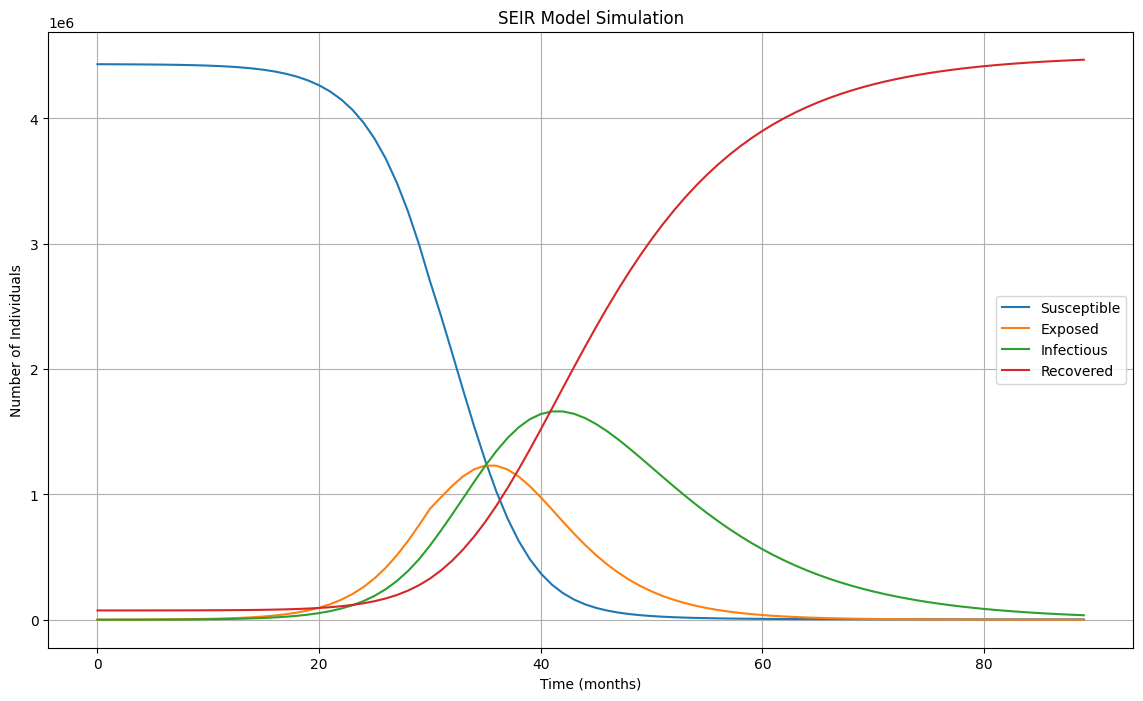

In [16]:
solution_meteo = odeint(seir_with_meteo, y0, time_array, args=(beta, sigma, gamma, temp_daily, rain_daily, humidity_daily))
simulated_cases_meteo = solution_meteo[:, 2] # Index 2 is the 'I' (Infected) compartment

S, E, I, R = solution_meteo.T # Transpose the solution to get S, E, I, R as separate arrays
SEIR = pd.DataFrame({
    'S': S,
    'E': E,
    'I': I,
    'R': R
})
# SEIR.to_csv('seir-forecast.csv', mode='w', index=False)

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, S, label='Susceptible')
plt.plot(time_array, E, label='Exposed')
plt.plot(time_array, I, label='Infectious')
plt.plot(time_array, R, label='Recovered')
plt.xlabel('Time (months)')
plt.ylabel('Number of Individuals')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

### Simulation 2: Standard SEIR forecast 

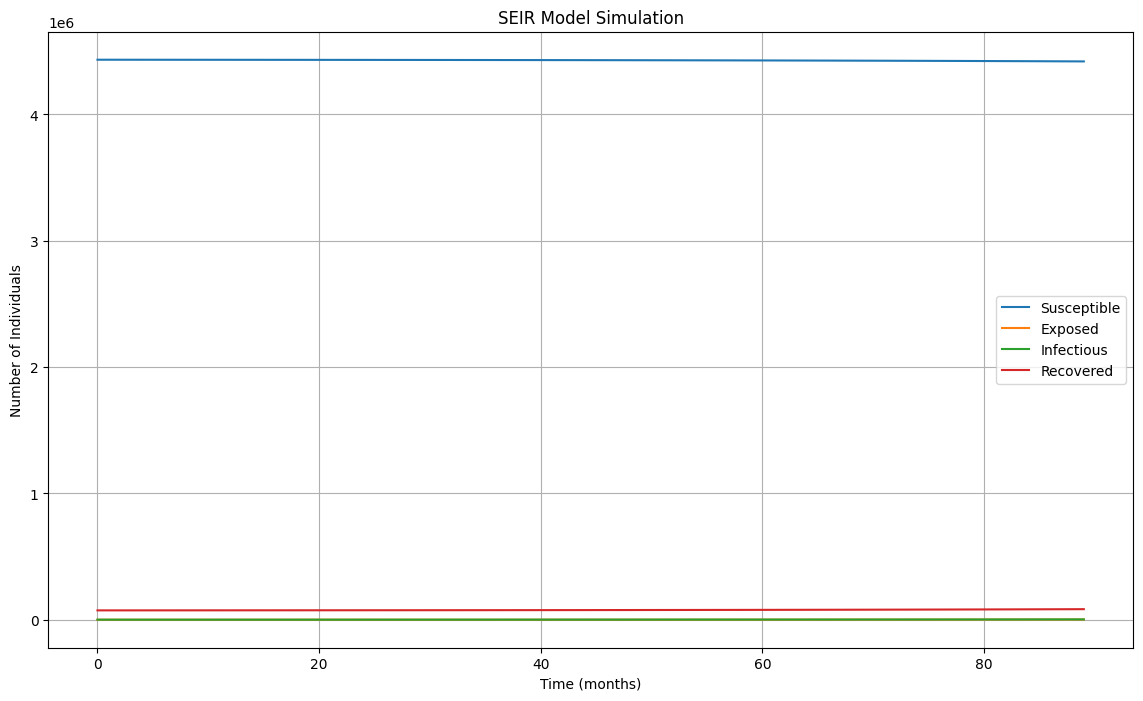

In [17]:
# 2. Run the simulation without meteorological factors
solution_no_meteo = odeint(standard_seir, y0, time_array, args=(beta, sigma, gamma))
simulated_cases_no_meteo = solution_no_meteo[:, 2]

S, E, I, R = solution_no_meteo.T # Transpose the solution to get S, E, I, R as separate arrays
SEIR = pd.DataFrame({
    'S': S,
    'E': E,
    'I': I,
    'R': R
})
# SEIR.to_csv('seir-forecast.csv', mode='w', index=False)

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, S, label='Susceptible')
plt.plot(time_array, E, label='Exposed')
plt.plot(time_array, I, label='Infectious')
plt.plot(time_array, R, label='Recovered')
plt.xlabel('Time (months)')
plt.ylabel('Number of Individuals')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Observed data (using our actual data from the past `t` days)
observed_cases = dengue_cases['New_cases'].tail(len(time_array)).values

## STATISTICAL ANALYSIS AND COMPARISON

In [19]:
# Evaluate the model with meteorological factors
rmse_meteo, r2_meteo = evaluate_model(observed_cases, simulated_cases_meteo)
print(f"Model WITH Meteorological Factors:")
print(f"  RMSE: {rmse_meteo:.2f}")
print(f"  R-squared: {r2_meteo:.2f}")

print("-" * 30)

# Evaluate the model without meteorological factors
rmse_no_meteo, r2_no_meteo = evaluate_model(observed_cases, simulated_cases_no_meteo)
print(f"Model WITHOUT Meteorological Factors:")
print(f"  RMSE: {rmse_no_meteo:.2f}")
print(f"  R-squared: {r2_no_meteo:.2f}")

# SOP 1: Comparison
print("-" * 30)
if rmse_meteo < rmse_no_meteo and r2_meteo > r2_no_meteo:
    print("Conclusion: Including meteorological factors IMPROVES forecast accuracy.")
    print("The factors have a significant effect on dengue transmission.")
else:
    print("Conclusion: Including meteorological factors does NOT improve forecast accuracy.")
    print("The factors may not have a significant effect, or the model's formulation needs adjustment.")

Model WITH Meteorological Factors:
  RMSE: 735826.89
  R-squared: -835281.34
------------------------------
Model WITHOUT Meteorological Factors:
  RMSE: 1213.77
  R-squared: -1.27
------------------------------
Conclusion: Including meteorological factors does NOT improve forecast accuracy.
The factors may not have a significant effect, or the model's formulation needs adjustment.


In [20]:
x = dengue_cases[['TMEAN', 'RAINFALL', 'RH']].tail(90)
y = dengue_cases['New_cases'].tail(90)

